# Pfam Data Analysis Task

_What is this Kaggle dataset?_

* Team at Google Research asked: Can we use modern Machine Learning to learn the relationship between (unaligned) protein domain sequences and their protein families? -> ProtCNN/ProtENN
* 'There are 17929 families in the Pfam database, may of which have very few sequences' [1]
* Benefits of using SOTA ProtCNN:
    * 'Our model co-locates sequences from unseen families in embedding space, allowing sequences from novel families to be accurately annotated.' [2] 
    * 'Deep learning provides an opportunity to bypass these bottlenecks {related to getting the alignment} and directly predict protein functional annotations from sequence data.' [2]


_Initial Thoughts_:

There are several classes and my prior is that biological datasets have a lot of noise so I think this will be a challenging learning task

Initially it seems very natural to frame this as an NLP task and then use a transformer for prediction as amino acids could corespond to words and positional information + attention should be important for complex protein sequences. Perhaps we can use RNNs/LSTMs as the protein sequence length + data size don't seem too large to result in a lot of gradient vanishing. I am not sure why ProtCNN uses a CNN based architecture as CNNs should be better for capturing local features. Using dilated CNN kernels slightly overcomes this. I can plug the data into a fancy deep learning model and hyperparameter tune but I am unsure of how to learn from such black box models and make intelligent improvements.

I am not a biologist and do not know what attributes of a sequence allow for accurate family classification. Nevertheless, we can utilise models and features of increasing complexity in order to understand what features are important and how expressive we require a model to be. 

tech used: 16GB CPU, 6GB GPU

## 1. Data Overview

- `sequence`: These are usually the input features to the model. Amino acid sequence for this domain. There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite uncommon: X, U, B, O, Z.

- `family_accession`: These are usually the labels for the model. Accession number in form PFxxxxx.y (Pfam), where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits.

- `sequence_name`: Sequence name, in the form "uniprot_accession_id/start_index-end_index". 

- `aligned_sequence`: Contains a single sequence from the multiple sequence alignment (with the rest of the members of the family in seed, with gaps retained.

- `family_id`: One word name for family. 

#### Example Data point



```
sequence: HWLQMRDSMNTYNNMVNRCFATCIRSFQEKKVNAEEMDCTKRCVTKFVGYSQRVALRFAE 
family_accession: PF02953.15
sequence_name: C5K6N5_PERM5/28-87
aligned_sequence: ....HWLQMRDSMNTYNNMVNRCFATCI...........RS.F....QEKKVNAEE.....MDCT....KRCVTKFVGYSQRVALRFAE 
family_id: zf-Tim10_DDP
```



#### Data split

- We have been provided with already done random split(train, val, test) of pfam dataset.
  - Train - 80% (For training the models).
  - Val - 10% (For hyperparameter tuning/model validation).
  - Test - 10% (For acessing the model performance).

## 2. Exploratory Data Analysis

### Importing Libraries

In [71]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
import tensorflow as tf
import time

from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, GlobalMaxPooling1D

### Loading Data

set data_path to dir that contains the dev, test, train folders

In [72]:
data_path = 'D:\Professional_Development\instadeep\data'
print('Available data', os.listdir(data_path))

Available data ['dev', 'test', 'train']


In [73]:
def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(data_path, partition)):
    with open(os.path.join(data_path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)

In [74]:
df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')

### Basic Statistics

In [75]:
print('Number of train data points: ', len(df_train))
print('Number of val data points', len(df_val))
print('Number of test data points ', len(df_test))

Number of train data points:  1086741
Number of val data points 126171
Number of test data points  126171


In [76]:
df_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [77]:
# ex: unaligned sequence
# each character reperesents one of the 24(20 common + 4 uncommon) amino acids in the sequence.
df_train.head(1)['sequence'][0]

'PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAILAAAGCAAPFEEFSSADAFSSTHVFGTCRMGHDPMRNVVDGWGRSHRWPNLFVADASLFPSSGGGESPGLTIQALALRT'

In [78]:
# verify family_accession and family_id have one to one mapping
assert (df_train.groupby('family_accession')['family_id'].nunique() == 1).all()
assert (df_train.groupby('family_id')['family_accession'].nunique() == 1).all()

In [79]:
def calc_unique_vals(col, train, test, val):
  """
  Prints # unique values in a column
  """
  train_unq = np.unique(train[col].values)
  val_unq = np.unique(val[col].values)
  test_unq = np.unique(test[col].values)

  print(f"Number of unique '{col}' in Train: ", len(train_unq))
  print(f"Number of unique '{col}' in Val: ", len(val_unq))
  print(f"Number of unique '{col}' in Test: ", len(test_unq))

# Unique family in the given dataset : [df_train, df_val and df_test]
calc_unique_vals('family_accession', df_train, df_test, df_val)

Number of unique 'family_accession' in Train:  17929
Number of unique 'family_accession' in Val:  13071
Number of unique 'family_accession' in Test:  13071


In [80]:
# for PFxxxxx.y, xxxx is always unique in this dataset
print(f"unique xxxx in train: {df_train['family_accession'].str.split('.').str[0].nunique()}")
print(f"unique xxxx in val: {df_val['family_accession'].str.split('.').str[0].nunique()}")
print(f"unique xxxx in test: {df_test['family_accession'].str.split('.').str[0].nunique()}")

unique xxxx in train: 17929
unique xxxx in val: 13071
unique xxxx in test: 13071


### Sequence Lengths

In [81]:
# Length of sequences in data.
df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))

In [82]:
from scipy.stats import percentileofscore

def plot_seq_count(df, data_name):
  print(df['seq_char_count'].median())
  print(df['seq_char_count'].describe())
  print(percentileofscore(df['seq_char_count'], 35))
  print(percentileofscore(df['seq_char_count'], 150))
  sns.histplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

119.0
count    1.086741e+06
mean     1.553800e+02
std      1.201232e+02
min      4.000000e+00
25%      7.600000e+01
50%      1.190000e+02
75%      1.950000e+02
max      2.037000e+03
Name: seq_char_count, dtype: float64
3.4387218297644058
62.78768354189268
118.0
count    126171.000000
mean        154.222206
std         118.278250
min           9.000000
25%          76.000000
50%         118.000000
75%         194.000000
max        1971.000000
Name: seq_char_count, dtype: float64
3.4532499544269286
63.1266297326644
118.0
count    126171.000000
mean        154.166845
std         118.376706
min           9.000000
25%          76.000000
50%         118.000000
75%         194.000000
max        1937.000000
Name: seq_char_count, dtype: float64
3.456420255050685
63.167447353195264


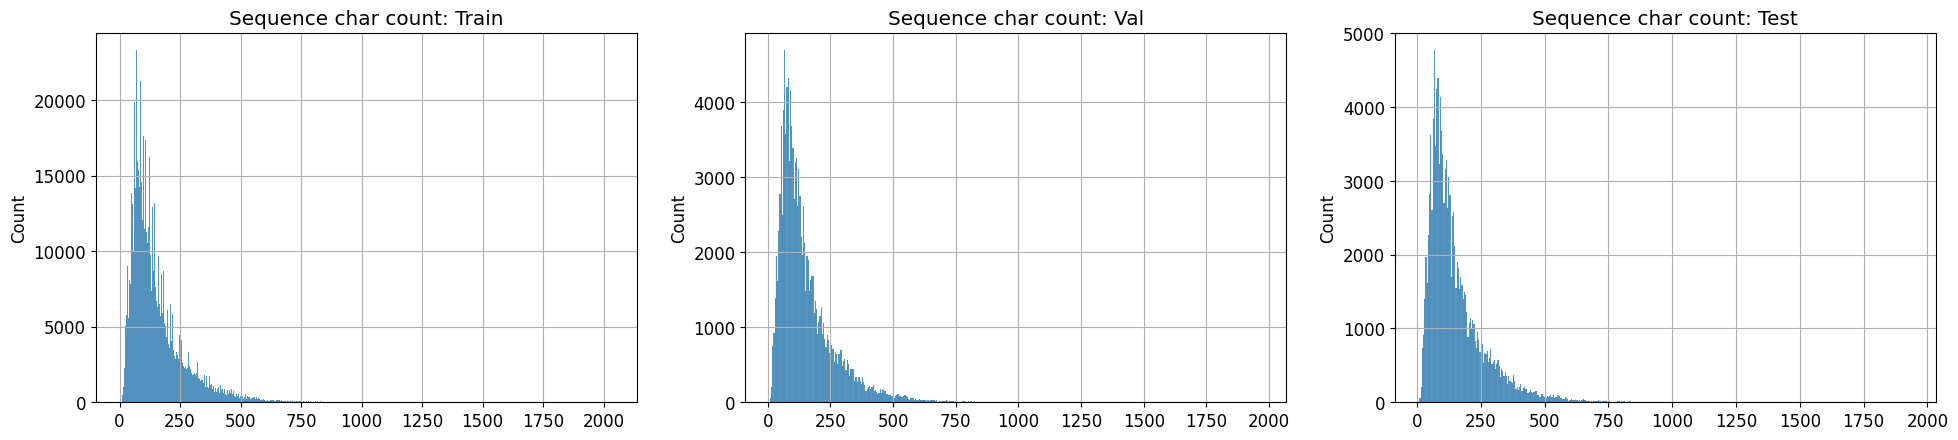

In [83]:
plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

__Observations__

- Middle 50% of unaligned amino acid sequences have character counts in the range of 75-200.
- The median sequence (more robust than the mean for skewed dist) is around 120 amino acids long

- Perhaps there is not much to learn from shorter sequences and ignoring them may lead to better generalization
- Perhaps allowing for longer sequences may result in our expressive deep learning models overfitting to strucutre present in the training dataset that is not representative of the whole data distribution

- a sequence of length 150 (padding length in deep learning section) is in the 62nd percentile
- a sequence of length 35 (cut off for short sequences) is in the 4th percentile

### Amino Acid Code Frequency

In [84]:
def get_code_freq(df, data_name):
  
  codes = []
  for i in df:
    codes.extend(i)

  codes_dict= Counter(codes)
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), f'{data_name} Freq': list(codes_dict.values())})
  return df.sort_values(f'{data_name} Freq', ascending=False).reset_index()[['Code', f'{data_name} Freq']]

In [85]:
# test code sequence
train_code_freq = get_code_freq(df_train['sequence'], 'Train')
val_code_freq = get_code_freq(df_val['sequence'], 'Val')
test_code_freq = get_code_freq(df_test['sequence'], 'Test')
pd.concat([train_code_freq.set_index('Code'), val_code_freq.set_index('Code'),test_code_freq.set_index('Code')],axis=1, join='outer')

Codes: Train
Total unique codes: 25
Codes: Val
Total unique codes: 22
Codes: Test
Total unique codes: 24


,Train Freq,Val Freq,Test Freq
Code,,,
L,17062816,1967025.0,1967046.0
A,14384873,1667703.0,1668137.0
V,11913147,1382128.0,1380962.0
G,11845579,1376124.0,1375349.0
E,10859966,1249356.0,1251000.0
S,10597822,1210750.0,1210559.0
I,10234455,1185722.0,1184239.0
R,9406165,1085950.0,1085786.0
D,9371097,1080572.0,1078379.0


In [86]:
def plot_code_freq(df, data_name):
  
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y=f'{data_name} Freq', data=df)

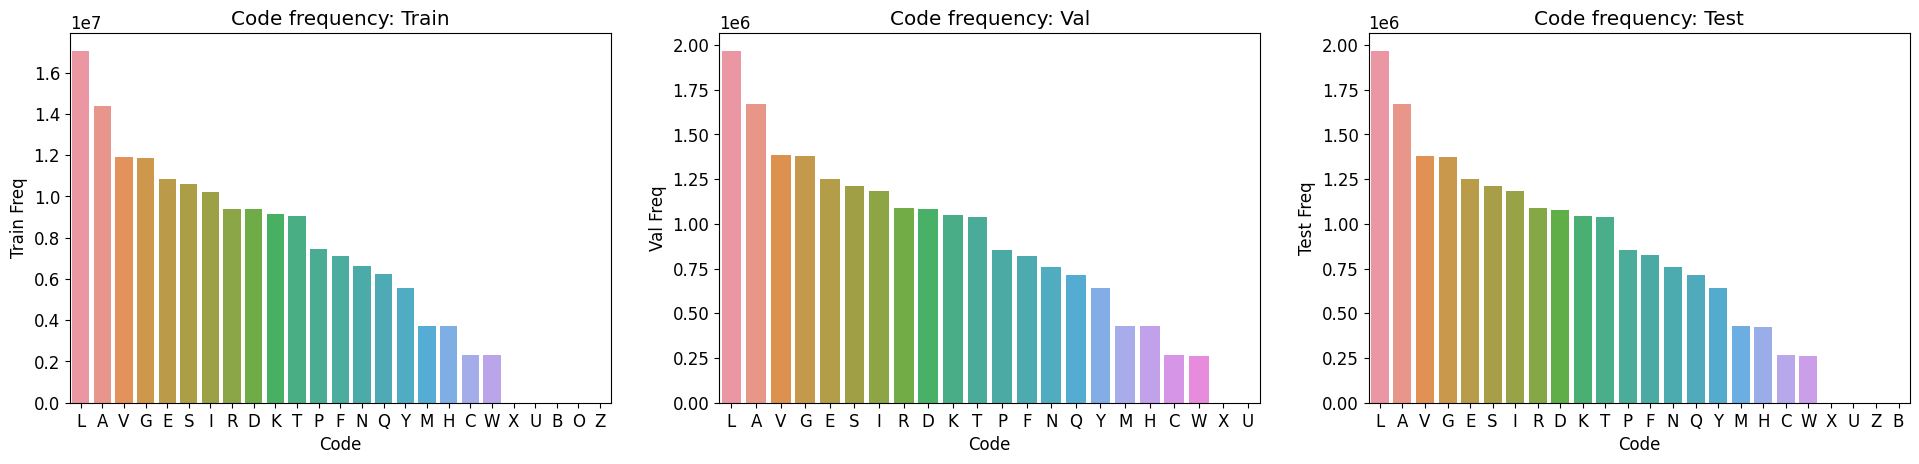

In [87]:
plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

__Observations__

- We verify the observations that the uncommon amino acids (i.e., X, U, B, O, Z) are very infrequent 
- Leaving sequences with these amino acids in the the datasets may lead to our model learning spurious correlations

### Number of sequences per family

In [88]:
def get_information(partitions):
    columns = ['partition', 'nb_samples', 'nb_families', 'min_samples_per_fam', 'max_samples_per_fam', 'mean_samples_per_fam']
    df_info = pd.DataFrame(columns=columns)
    
    for name, df in partitions.items():
        
        row = {
        'partition': name,
        'nb_samples': len(df),
        'nb_families': df['family_accession'].unique().size,
        'max_samples_per_fam': df.groupby('family_accession').size().max(),
        'min_samples_per_fam': df.groupby('family_accession').size().min(),
        'mean_samples_per_fam': df.groupby('family_accession').size().mean(),
        'median_samples_per_fam': df.groupby('family_accession').size().median()
        }
        
        new_df = pd.DataFrame([row])
        df_info = pd.concat([df_info, new_df], axis= 0, ignore_index=True)
    return df_info

partitions = {'train': df_train, 'val': df_val, 'test': df_test}
get_information(partitions)

,partition,nb_samples,nb_families,min_samples_per_fam,max_samples_per_fam,mean_samples_per_fam,median_samples_per_fam
0,train,1086741,17929,1,3637,60.613587,22.0
1,val,126171,13071,1,454,9.652743,4.0
2,test,126171,13071,1,454,9.652743,4.0


In [89]:
print(df_train['family_id'].nunique())
print(df_val['family_id'].nunique())
print(df_test['family_id'].nunique())
pd.concat([
    df_train.groupby('family_id').size().sort_values(ascending=False).head(20),
    df_val.groupby('family_id').size().sort_values(ascending=False).head(20),
    df_test.groupby('family_id').size().sort_values(ascending=False).head(20)], 
    axis = 1, 
    keys = ['train', 'val', 'test'])


17929
13071
13071


,train,val,test
family_id,,,
Methyltransf_25,3637,454,454
LRR_1,1927,240,240
Acetyltransf_7,1761,219,219
His_kinase,1537,192,192
Bac_transf,1528,190,190
Lum_binding,1504,187,187
DNA_binding_1,1345,168,168
Chromate_transp,1265,157,157
Lipase_GDSL_2,1252,156,156


In [90]:
common_test_families = df_test.groupby('family_accession').size().sort_values(ascending=False).index
# list(common_test_families)

In [91]:
def plot_num_seq(df, data_name, scale = 'log'):
  df.groupby('family_id').size().hist(bins=50)
  plt.title(f'Distribution of family sizes for: {data_name}')
  plt.ylabel('# Families')
  if scale == 'log':
    plt.yscale("log")
  plt.xlabel('Family size')
  plt.show()


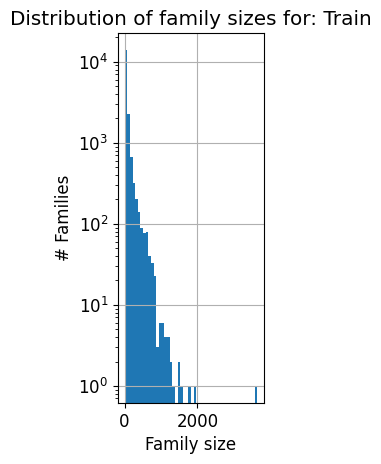

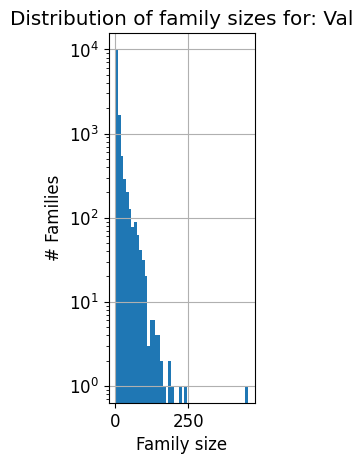

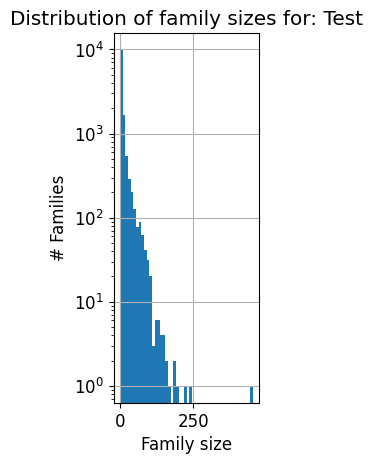

<Figure size 640x480 with 0 Axes>

In [92]:
plt.subplot(1, 3, 1)
plot_num_seq(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_num_seq(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_num_seq(df_test, 'Test')

# plt.subplots_adjust(right=3.0)
plt.subplots_adjust(wspace=0.5)
plt.show()

In [93]:
# cut off used in [2] leaves 12361 families in train dataset
df_check = df_train.groupby('family_id').size().sort_values(ascending=False)
df_check.loc[df_check > 9]

family_id
Methyltransf_25    3637
LRR_1              1927
Acetyltransf_7     1761
His_kinase         1537
Bac_transf         1528
                   ... 
PET10                10
Squash               10
JAKMIP_CC3           10
DUF4527              10
DNA_pol3_beta        10
Length: 12361, dtype: int64

count     250.000000
mean      737.776000
std       277.235952
min       537.000000
25%       592.250000
50%       663.000000
75%       777.000000
max      3637.000000
dtype: float64


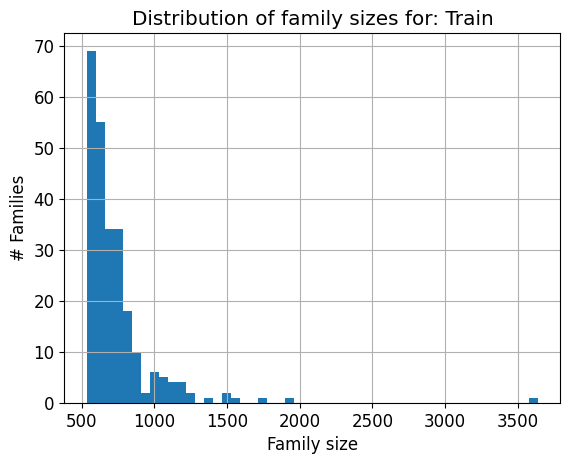

In [94]:
df_filtered = df_train.loc[df_train.family_accession.isin(common_test_families[:250])]
print(df_filtered.groupby('family_id').size().describe())
plot_num_seq(df_filtered, 'Train', scale = 'normal')

__Observations__

* Very unbalanced dataset with >exponential decay in the distribution of families plots and F1 metric should be used
* After filtering to keep only the top 250 families we have a more balanced distribution that doesnt have any family with fewer than 530 sequences
* Using accuracy as a performance metric with this filtered number of families is feasible here
---------------------------------------------------------------------------------------------------------

* Top 20 classes are same across all the sets [train, test, val].
* Test and Val sets have the same frequency for the top 20 classes.
---------------------------------------------------------------------------------------------------------

* Families of larger size more likely to be easier to learn
* Families of only a few sequences will be harder to learn (what could we possible learn from the families with 1 sequence)

## 3. Data Filtering

* After a painful process of running out of GPU memory for reasonable batch sizes and other hyperparameters I need to reduce the size of the datasets for meaningful analysis given computational restrictions
* There are also concerns of using subsets of the data described in the previous section that we can resolve by doing this filtering process

### F1: Remove sequences with amino acids in {X, U, B, O, Z}
* F1 = filter round 1
* minor affect on size of datasets

In [95]:
def acid_count(df, acids):
    for aa in acids:
        df[f'counts_{aa}'] = df.sequence.apply(lambda x: x.count(aa)) / df.seq_char_count
        # alignedness is feature used in random forest
        df['alignedness'] = df.seq_char_count / df['aligned_sequence'].apply(lambda x: len(x))
    return df

df_train = acid_count(df_train, train_code_freq['Code'].values)
df_val = acid_count(df_val, val_code_freq['Code'].values)
df_test = acid_count(df_test, test_code_freq['Code'].values)

In [96]:
low_amino = [f"counts_{aa}" for aa in ['X', 'U', 'B', 'O','Z']]
for column in low_amino:
    df_train = df_train.loc[df_train[column] == 0]

low_amino = [f"counts_{aa}" for aa in ['X', 'U']]
for column in low_amino:
    df_val = df_val.loc[df_val[column] == 0]

low_amino = [f"counts_{aa}" for aa in ['X', 'U', 'B', 'Z']]
for column in low_amino:
    df_test = df_test.loc[df_test[column] == 0]

### F2: Remove sequences with length < 35
* arbitrary threshold, further domain knowledge may give a better guess as to how short is too short
* sequences too long for overly expressive deep learning models handled later by padding max_length

In [97]:
check = df_train['seq_char_count'].sort_values()
print(len(check.loc[check > 35])/len(check))

0.9641997784414099


In [98]:
df_train = df_train.loc[df_train.seq_char_count > 35]
df_val = df_val.loc[df_val.seq_char_count > 35]
df_test = df_test.loc[df_test.seq_char_count > 35]

### F3: Keep the top 250 families in terms of number of sequences
* Major change to dataset size, this is too much of a reduction in my opinion but I faced too many GPU memory issues otherwise
* 'We proceed by training a ProtCNN model on the subset of Pfam-seed families that have more than 9 training sequences' [2] 
* This approach is far stricter than ProtCNN

In [99]:
# Considering top 250 classes based on most observations because of limited computational power and concerns mentioned previously

classes = df_train['family_accession'].value_counts()[:250]
classes = classes.index.tolist()

In [100]:
df_train = df_train.loc[df_train['family_accession'].isin(classes)].reset_index()
df_val = df_val.loc[df_val['family_accession'].isin(classes)].reset_index()
df_test = df_test.loc[df_test['family_accession'].isin(classes)].reset_index()

print('Data size after considering 250 classes for each data split:')
print('Train size:', len(df_train))
print('Val size:', len(df_val))
print('Test size:', len(df_test))

Data size after considering 250 classes for each data split:
Train size: 181976
Val size: 22608
Test size: 22614


# 4: Simpler Models

### Model 0: Majority vote

* A useful baseline to check is that if we had a classifier, what would the accuracy be if we simply picked the family with the largest number of sequences in the training data set. 

In [101]:
print(f"Family with most sequences in training dataset: {df_train.groupby('family_id').size().sort_values(ascending=False).index[0]}")
print(f"Number of sequences in training dataset of that family: {df_train.groupby('family_id').size().sort_values(ascending=False)[0]}")
print(f"Accuracy of majority vote on train set (in sample): {round(100 * len(df_train.loc[df_train['family_id'] == 'Methyltransf_25'])/len(df_train), 4)}%")
print(f"Accuracy of majority vote on test set (OOS): {round(100 * len(df_test.loc[df_test['family_id'] == 'Methyltransf_25'])/len(df_test), 4)}%")
print(f"If the classes were evenly balanced, the accuracy would be: {100 * 1/250}%")

Family with most sequences in training dataset: Methyltransf_25
Number of sequences in training dataset of that family: 3637
Accuracy of majority vote on train set (in sample): 1.9986%
Accuracy of majority vote on test set (OOS): 2.0076%
If the classes were evenly balanced, the accuracy would be: 0.4%


In [102]:
from sklearn.metrics import f1_score
y_pred = []
for i in range(len(df_test)):
    y_pred.append('PF13649.6')
f1_score(list(df_test['family_accession']), y_pred, average='micro')

0.02007605907844698

### Model 1: Random Forest + Simple hand crafted features

* I have a naive idea for features we can create and that RF can injest:
    * For each protein domain we could get the proportion of each amino acid in the sequence as features
    * We can also let the model know the length of the sequence
    * Perhaps how 'aligned' a sequence is may be useful. If len(aligned_sequence) >> len(sequence) this is very 'aligned'
    * I will use RF with shallow trees instead of gradient boosting to prevent overfitting and just understand how well simple relationships can classify


In [103]:
# Prepare train & test set
features = [f for f in df_val.columns if f.startswith('counts_')] + ['seq_char_count', 'alignedness']

X_train = df_train[features].values.copy()
y_train = df_train.family_accession.values
X_val = df_val[features].values.copy()
y_val = df_val.family_accession.values
X_test = df_test[features].values.copy()
y_test = df_test.family_accession.values

In [104]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_val_pred = clf.predict(X_val)
y_train_pred = clf.predict(X_train)

In [105]:
test_correct = 0
train_correct = 0
val_correct = 0

for idx in range(len(y_pred)):
    if y_pred[idx] == y_test[idx]:
        test_correct += 1

for idx in range(len(y_train_pred)):
    if y_train_pred[idx] == y_train[idx]:
        train_correct += 1

for idx in range(len(y_val_pred)):
    if y_val_pred[idx] == y_val[idx]:
        val_correct += 1

print(f"Random Forest in sample accuracy: {round(train_correct*100/len(y_train_pred), 4)}%")
print(f"Random Forest out of sample accuracy (val): {round(val_correct*100/len(y_val_pred), 4)}%")
print(f"Random Forest out of sample accuracy (test): {round(test_correct*100/len(y_pred), 4)}%")
f1_score(y_test, y_pred, average='micro')

Random Forest in sample accuracy: 37.5467%
Random Forest out of sample accuracy (val): 37.1948%
Random Forest out of sample accuracy (test): 37.3176%


0.3731759087291059

In [106]:
# amino acids C, G, D and 2 length features seem to be reasonably important for prediction 
pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)

seq_char_count    0.205201
counts_C          0.163539
alignedness       0.163239
counts_G          0.065135
counts_D          0.064891
counts_W          0.059018
counts_E          0.039987
counts_L          0.037172
counts_Y          0.032959
counts_P          0.030689
counts_K          0.019622
counts_T          0.017474
counts_H          0.017207
counts_A          0.015570
counts_F          0.015485
counts_R          0.015172
counts_M          0.009808
counts_N          0.008237
counts_I          0.008028
counts_V          0.005801
counts_Q          0.003951
counts_S          0.001816
counts_X          0.000000
counts_U          0.000000
dtype: float64

From 2% accuracy we have a ~20x improvement to 38% with a shallow model with very simple and naively constructed features.

In [107]:
# Remove 'alignedness' feature as ProtCNN does not have access to anything about aligned structure
features = [f for f in df_val.columns if f.startswith('counts_')] + ['seq_char_count']

X_train = df_train[features].values.copy()
y_train = df_train.family_accession.values
X_val = df_val[features].values.copy()
y_val = df_val.family_accession.values
X_test = df_test[features].values.copy()
y_test = df_test.family_accession.values

In [108]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_val_pred = clf.predict(X_val)
y_train_pred = clf.predict(X_train)

In [109]:
test_correct = 0
train_correct = 0
val_correct = 0

for idx in range(len(y_pred)):
    if y_pred[idx] == y_test[idx]:
        test_correct += 1

for idx in range(len(y_train_pred)):
    if y_train_pred[idx] == y_train[idx]:
        train_correct += 1

for idx in range(len(y_val_pred)):
    if y_val_pred[idx] == y_val[idx]:
        val_correct += 1

print(f"Random Forest in sample accuracy: {round(train_correct*100/len(y_train_pred), 4)}%")
print(f"Random Forest out of sample accuracy (val): {round(val_correct*100/len(y_val_pred), 4)}%")
print(f"Random Forest out of sample accuracy (test): {round(test_correct*100/len(y_pred), 4)}%")

Random Forest in sample accuracy: 30.1309%
Random Forest out of sample accuracy (val): 29.6267%
Random Forest out of sample accuracy (test): 29.5746%


In [110]:
# amino acids C, G, D and 2 length features seem to be reasonably important for prediction 
pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)

seq_char_count    0.295772
counts_C          0.155165
counts_G          0.092153
counts_W          0.060706
counts_E          0.059835
counts_L          0.051891
counts_D          0.043234
counts_P          0.037675
counts_Y          0.032790
counts_F          0.031883
counts_K          0.022891
counts_R          0.017668
counts_M          0.014910
counts_V          0.014584
counts_Q          0.014305
counts_A          0.013369
counts_H          0.011108
counts_I          0.010772
counts_N          0.009475
counts_T          0.008135
counts_S          0.001677
counts_X          0.000000
counts_U          0.000000
dtype: float64

7% drop off in accuracy after removing 'alignedness' when using a few shallow decision trees. ProtCNN was resticted to not using information from aligned_sequence.

_Obervations_

* I am not comfortable making bold claims without doing significant hyperparameter tuning with different cross validation splits of the data but here:
    * I just want do see what a few shallow decision trees can learn, not the optimum RF model
    * In the ProtCNN paper the authors detail the importance of their data split provided so i will not do any cross validation

With extremely simple features and a few shallow decision trees we are able to get 30-40% accuracy and there is likely significant room for improvement with hyperparameter choice.  
This learning problem does not seem as challenging as I initially believed. 

## Model 2: Transitions

- We can go beyond just simple learning global level features (such as fraction of amino acids = 'C')
- Information on local features such as how frequently a certain amino acids switches to another may be useful.


In [220]:
def seq_transition_matrix(sequence, default_matrix):
    df = pd.DataFrame(sequence)
    df['shift'] = df[0].shift(-1)
    df['count'] = 1
    transition_matrix = df.groupby([0, 'shift']).count().unstack().fillna(0)
    transition_matrix.columns = transition_matrix.columns.droplevel()
    return (default_matrix + transition_matrix).fillna(0)

def overall_transition_matrix(data_frame, family_id):
    family_sequences = data_frame.loc[data_frame.family_id == family_id]['sequence'].reset_index(drop=True)
    amino_acids = [aa for aa in 'GALMFWKQESPVICYHRNDTXUBOZ']
    sequences = family_sequences.apply(lambda seq: [aa for aa in seq])
    default_matrix = pd.DataFrame([[0] * len(amino_acids)] * len(amino_acids),
                                  columns=amino_acids, index=amino_acids, dtype='int64')
    transition_matrix = default_matrix.copy()
    for seq in sequences:
        transition_matrix += seq_transition_matrix(seq, default_matrix)
    
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).replace(np.nan, 0)
    return transition_matrix


<AxesSubplot: >

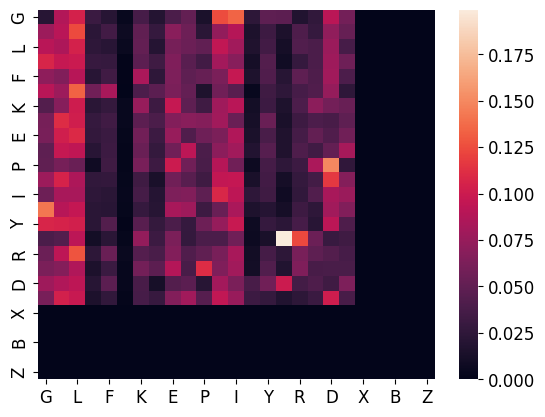

In [221]:
sns.heatmap(overall_transition_matrix(df_train, 'DHH'))

In [222]:
percentileofscore(df_train['seq_char_count'], 200)

78.76780454565437

* We can generate a noramlised average transition matrix for each family from the training set. 
    * Then, we can compute the forbenius norm between a query sequence normalised transition matrix (from the test set) and each family transition matrix. 
    * Alternatively, we can repeat the RF example above but have 400 extra columns representing each transition probability from a sequences transition matrix 

As only 20% of filtered sequences are even longer than 200 I am not very optimistic of these techniques. With the first technique we could use a different norm that penalises deviations far from the average transition matrix from the training data (something like the wasserstein distance)

In [223]:
# Code for getting the transition probability of each amino acid transition for each sequence below
# I was planning on using this to add more columns to the RF example in the previous section
# It was too computationally slow to create and I was not optimistic of its ability anyway

# from tqdm import tqdm

# def trans_row(sequence, i):
#     df = pd.DataFrame(sequence)
#     df['shift'] = df[0].shift(-1)
#     df['count'] = 1
#     df = df.groupby([0, 'shift']).count()
#     df = df.groupby(level=0)['count'].transform(lambda x: x / x.sum())
#     new_idx = df.index.get_level_values(0) + df.index.get_level_values(1)
#     df = df.reset_index()['count']
#     df.index = new_idx
#     df = df.rename(i)
#     if i == 0:
#         return df
#     else:
#         return pd.concat([final, df], axis = 1)

# family_sequences = df_train['sequence'].reset_index(drop=True)
# amino_acids = [aa for aa in 'GALMFWKQESPVICYHRNDTXUBOZ']
# sequences = family_sequences.apply(lambda seq: [aa for aa in seq])

# for i, seq in tqdm(enumerate(sequences)):
#     df_transitions = trans_row(seq, i)
# df_transtitions


# 5. Deep Learning Models

In [55]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_dict = {}
for index, val in enumerate(codes):
  char_dict[val] = index+1

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [56]:
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  
  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list

train_encode = integer_encoding(df_train) 
val_encode = integer_encoding(df_val) 
test_encode = integer_encoding(df_test) 

In [57]:
# I am not sure how to pad each batch to be the length of the max sequence in the batch [2] 
# so I will apply a 200 length limit on all sequences and pad the remiander of each sequence
# this removes a lot of information but this helps with running out of GPU memory and avoids overfitting to spurious patterns in excessively long sequences

max_length = 200
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

print(train_pad.shape, val_pad.shape, test_pad.shape)

(181976, 200) (22608, 200) (22614, 200)


In [58]:
set(df_train['family_accession']) == set(df_val['family_accession']) == set(df_test['family_accession'])

True

In [59]:
# One hot encoding of sequences
train_ohe = to_categorical(train_pad)
val_ohe = to_categorical(val_pad)
test_ohe = to_categorical(test_pad)
print(train_ohe.shape, test_ohe.shape, test_ohe.shape)

# label/integer encoding output variable: (y)
le = LabelEncoder()
y_train_le = le.fit_transform(df_train['family_accession'])
y_val_le = le.transform(df_val['family_accession'])
y_test_le = le.transform(df_test['family_accession'])
print(y_train_le.shape, y_val_le.shape, y_test_le.shape)

# One hot encoding of outputs
y_train = to_categorical(y_train_le)
y_val = to_categorical(y_val_le)
y_test = to_categorical(y_test_le)

y_train.shape, y_val.shape, y_test.shape

(181976, 200, 21) (22614, 200, 21) (22614, 200, 21)
(181976,) (22608,) (22614,)


((181976, 250), (22608, 250), (22614, 250))

In [60]:
# Plotting Helper Functions
def visualize_training_history(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs = range(1, len(training_accuracy) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_loss, 'b', label='Training Loss')
    plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# def display_model_scores(model, train_data, val_data, test_data, batch_size):
def display_model_scores(model, test_data, batch_size):
    def print_scores(name, scores):
        print(f'{name} loss: {scores[0]}')
        print(f'{name} accuracy: {scores[1]}')
        print('-' * 70)

    # train_scores = model.evaluate(train_data[0], train_data[1], batch_size=batch_size, verbose=1)
    # print_scores('Train', train_scores)

    # val_scores = model.evaluate(val_data[0], val_data[1], batch_size=batch_size, verbose=1)
    # print_scores('Validation', val_scores)

    test_scores = model.evaluate(test_data[0], test_data[1], batch_size=batch_size, verbose=1)
    print_scores('Test', test_scores)

In [61]:
from sklearn.manifold import TSNE
def visualize_seq_embeddings(model, num_most_frequent_labels, name = 'normal'):
    
    x_test_pre_class_embeds = []
    if name == 'protcnn':
        batch_size = 4
        test_dataset = tf.data.Dataset.from_tensor_slices(test_ohe)
    else:
        batch_size = 16
        test_dataset = tf.data.Dataset.from_tensor_slices(test_pad)
    test_dataset = test_dataset.batch(batch_size)
    for x_batch in test_dataset.as_numpy_iterator():
        x_test_pre_class_embeds.append(model.get_embedding_output(x_batch))

    x_test_pre_class_embeds = np.vstack(x_test_pre_class_embeds)    
    x_test_tsne = TSNE(n_components=2,random_state=420).fit_transform(x_test_pre_class_embeds)
    
    plot_df = df_test[["family_accession"]].copy()
    plot_df["PC1"] = x_test_tsne[:,0]
    plot_df['PC2'] = x_test_tsne[:,1]
    plot_df_top_label = plot_df.loc[plot_df.family_accession.isin(common_test_families[:num_most_frequent_labels])]
    plot_df_top_label.reset_index(inplace=True)
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(8,8))
    sns.jointplot(data=plot_df_top_label, x='PC1', y='PC2', hue = 'family_accession', height=10)

### Model 4: Keras Embedding Layer + Softmax

* Before we try the SOTA ProtCNN model I am interested to see what happens when we replace the customised embedding architecture with a standard keras embedding layer and just have a softmax classifier on top.
* If we want added complexity, it would be interesting to see if having positional encoding + a transformer block and treat it like a standard modern NLP problem.

In [133]:
embedding_dim = 32
input_dim= 21

class Baseline(tf.keras.Model):
    def __init__(self, input_dim, embedding_dim, out_dim, max_seq_len, dropout_rate=0.2, embedding_type="vanilla"):
        super(Baseline, self).__init__()
        self.max_seq_len = max_seq_len
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim)
        self.flatten = Flatten()
        self.embedding_dropout = Dropout(dropout_rate)
        self.embedding_proj = Dense(128, activation="gelu")
        self.embedding_proj_dropout = Dropout(dropout_rate)
        self.classifier = Dense(out_dim, activation="softmax")
        
    def get_embedding_output(self, x, training=False):
        x = self.embedding(x)
        x = self.embedding_dropout(x, training)
        x = self.flatten(x)
        x = self.embedding_proj(x)
        # I believe this is an appropriate layer to examine a 
        # low dimensional representation of the embeddings
        x = self.embedding_proj_dropout(x, training)
        return x
    
    def call(self, inputs, training=False):
        return self.classifier(self.get_embedding_output(inputs, training))
    
embed_model = Baseline(input_dim, embedding_dim, num_labels, max_seq_len)
embed_model(train_pad[:0])
embed_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
embed_model.summary()

Model: "baseline_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  672       
                                                                 
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dropout_7 (Dropout)         multiple                  0         
                                                                 
 dense_7 (Dense)             multiple                  819328    
                                                                 
 dropout_8 (Dropout)         multiple                  0         
                                                                 
 dense_8 (Dense)             multiple                  32250     
                                                                 
Total params: 852,250
Trainable params: 852,250
Non-trai

In [134]:
embed_history = embed_model.fit(
    train_pad, 
    y_train,
    epochs=5, 
    batch_size=16,
    validation_data=(val_pad, y_val),
    callbacks=[es]
)

Epoch 1/5
11374/11374 [==============================] - 54s 5ms/step - loss: 0.2833 - accuracy: 0.9368 - val_loss: 0.0538 - val_accuracy: 0.9868
Epoch 2/5
11374/11374 [==============================] - 50s 4ms/step - loss: 0.0713 - accuracy: 0.9806 - val_loss: 0.0544 - val_accuracy: 0.9885
Epoch 3/5
11374/11374 [==============================] - 49s 4ms/step - loss: 0.0536 - accuracy: 0.9850 - val_loss: 0.0562 - val_accuracy: 0.9885
Epoch 4/5
11374/11374 [==============================] - 50s 4ms/step - loss: 0.0472 - accuracy: 0.9870 - val_loss: 0.0567 - val_accuracy: 0.9892
Epoch 4: early stopping


In [135]:
# saving model weights.
embed_model.save_weights('./weights/embed.h5')

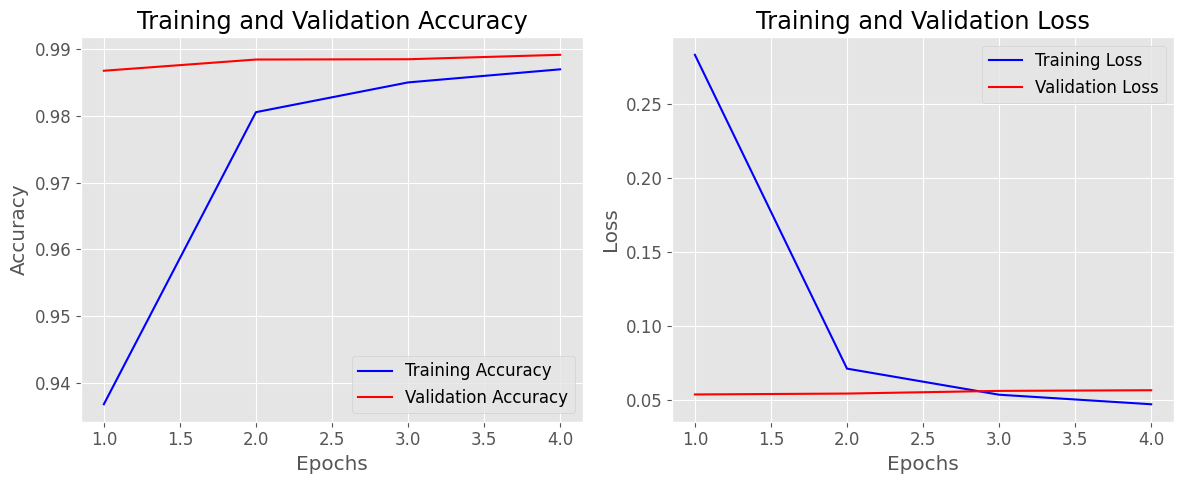

In [136]:
visualize_training_history(embed_history)

Validation accuracy is high from the first epoch and remains high which indicates negligable additional overfitting occured during training. 

In [141]:
display_model_scores(
    embed_model,
    [test_pad, y_test],
    16)

1414/1414 [==============================] - 4s 3ms/step - loss: 0.0447 - accuracy: 0.9901
Test loss: 0.044650573283433914
Test accuracy: 0.9900504350662231
----------------------------------------------------------------------


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 800x800 with 0 Axes>

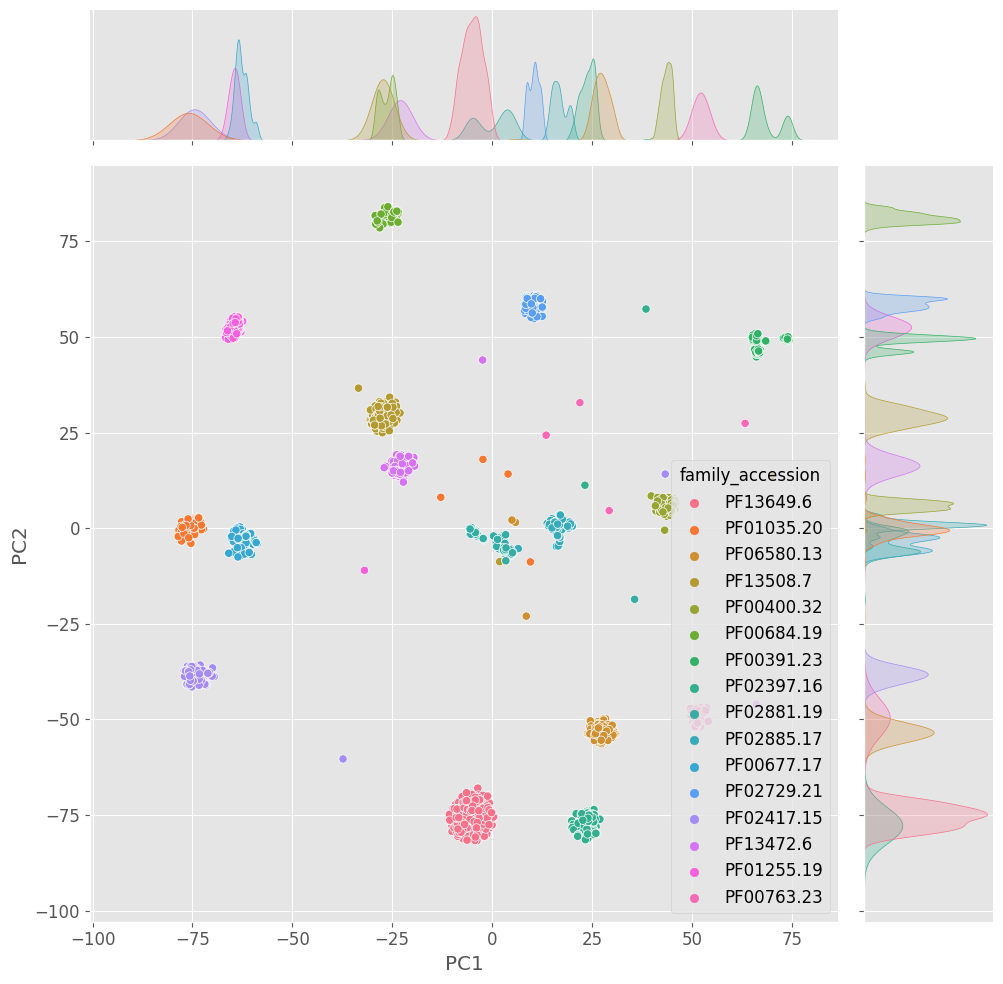

In [138]:
visualize_seq_embeddings(embed_model, num_most_frequent_labels=16)

We see very clear seperation of the most common families in a lower dimensional representation of the embeddings

### Model 5: ProtCNN [2]

- I attempted to recreate the ProtCNN model from the referenced paper, due to computational restrictions I needed to reduce some hyperparameters

<br/>
<center><img src='https://www.biorxiv.org/content/biorxiv/early/2019/07/15/626507/F6.large.jpg' height='470' width='700'></center>

<br/>

- The per residue representation + max pool act as an embedding network 
- One hot encoded unaligned sequence of amino acids is passed as the input to the network with zero padding.


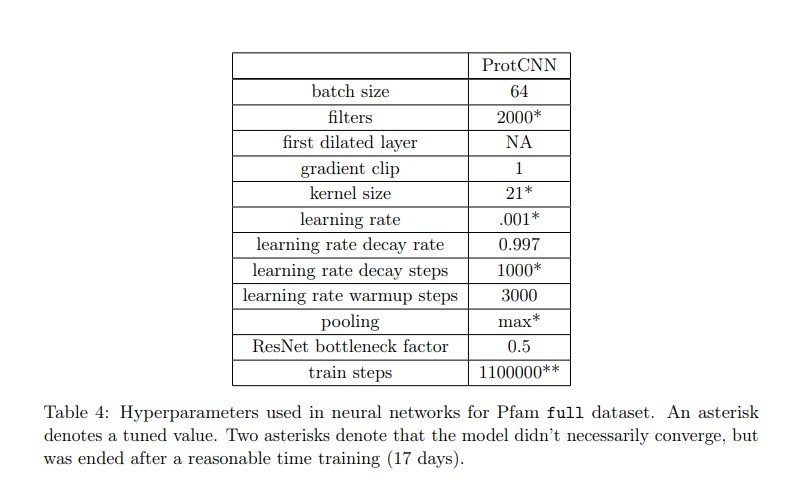

Values from supplementary material above

In [63]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, d_rate):
        super(ResidualBlock, self).__init__()
        self.bn = BatchNormalization()
        self.act = Activation('relu')
        self.conv = Conv1D(filters, kernel_size, padding='same', dilation_rate=d_rate)

    def call(self, inputs, training=False):
        x = self.bn(inputs)
        x = self.act(x)
        x = self.conv(x)
        return tf.keras.layers.add([inputs, x])

class ProtCNNModel(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(ProtCNNModel, self).__init__()
        self.conv = Conv1D(128, 1, padding='same')
        # I should be working with 1100 filters if following [2] but OOM issues
        # A kernel size of 21 would also follow the paper but OOM issues
        # Also I would have liked to try larger dilations
        self.res1 = ResidualBlock(filters=128, kernel_size=1, d_rate=2)
        self.res2 = ResidualBlock(filters=128, kernel_size=3, d_rate=1)
        self.maxpool = MaxPooling1D(3)
        self.dropout = Dropout(0.5)
        self.flatten = Flatten()
        self.x_output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.0001))

    def get_embedding_output(self, inputs, training=False):
        x = self.conv(inputs)
        x = self.res1(x, training=training)
        x = self.res2(x, training=training)
        x = self.maxpool(x)
        x = self.dropout(x)
        # I believe this is an appropriate layer to examine a 
        # low dimensional representation of the embeddings
        x = self.flatten(x) 
        return x

    def call(self, inputs, training=False):
        x = self.get_embedding_output(inputs, training=training)
        return self.x_output(x)

# Assuming input_dim and num_labels are defined
input_dim = 21
num_labels = 250
max_seq_len = 150

protcnn = ProtCNNModel(input_shape=(max_seq_len, input_dim), num_classes=num_labels)
protcnn(train_ohe[:0])
protcnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
protcnn.summary()

Model: "prot_cnn_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           multiple                  2816      
                                                                 
 residual_block_2 (ResidualB  multiple                 17024     
 lock)                                                           
                                                                 
 residual_block_3 (ResidualB  multiple                 49792     
 lock)                                                           
                                                                 
 max_pooling1d_1 (MaxPooling  multiple                 0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                  

In [64]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

protcnn_history = protcnn.fit(
    train_ohe, 
    y_train,
    epochs=5, 
    batch_size=16,
    validation_data=(val_ohe, y_val),
    callbacks=[es]
    )

Epoch 1/5
11374/11374 [==============================] - 484s 42ms/step - loss: 0.6605 - accuracy: 0.9555 - val_loss: 0.4805 - val_accuracy: 0.9903
Epoch 2/5
11374/11374 [==============================] - 406s 36ms/step - loss: 0.4346 - accuracy: 0.9842 - val_loss: 0.3727 - val_accuracy: 0.9921
Epoch 3/5
11374/11374 [==============================] - 89s 8ms/step - loss: 0.3655 - accuracy: 0.9867 - val_loss: 0.3316 - val_accuracy: 0.9922
Epoch 4/5
11374/11374 [==============================] - 94s 8ms/step - loss: 0.3454 - accuracy: 0.9870 - val_loss: 0.3299 - val_accuracy: 0.9923
Epoch 5/5
11374/11374 [==============================] - 96s 8ms/step - loss: 0.3377 - accuracy: 0.9874 - val_loss: 0.3235 - val_accuracy: 0.9936


In [66]:
# saving model weights.
protcnn.save_weights('./weights/protcnn.h5')

In [57]:
# model = ProtCNNModel(input_shape=(max_seq_len, input_dim), num_classes=num_labels)
# model(train_ohe[:0])
# model.load_weights('./weights/protcnn.h5')
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
protcnn.evaluate(test_ohe, y_test, batch_size=1, verbose=1)

22614/22614 [==============================] - 82s 4ms/step - loss: 0.3249 - accuracy: 0.9927


[0.3248710036277771, 0.9927478432655334]

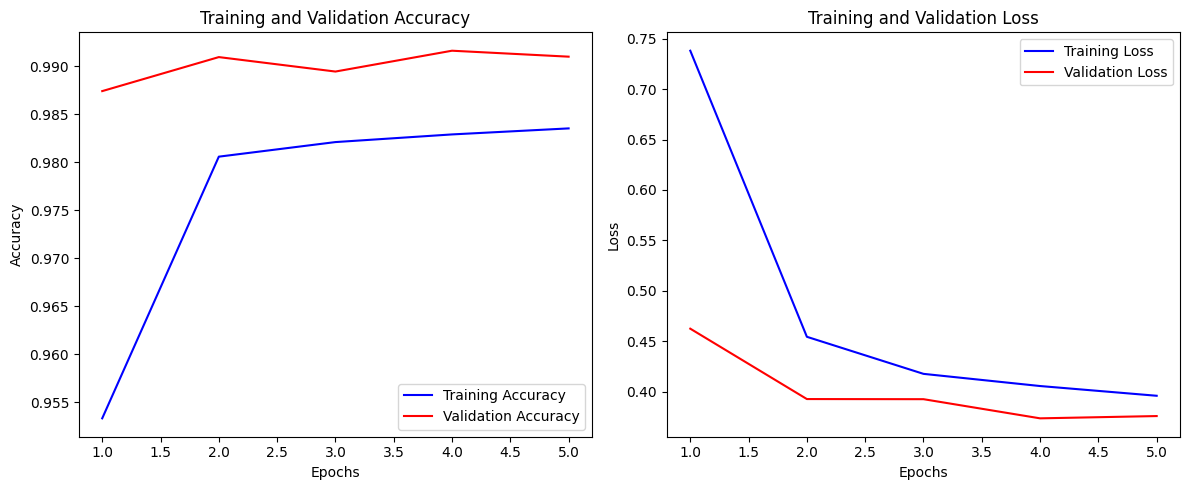

In [48]:
visualize_training_history(protcnn_history)

We see very similar behaviour in the evolution of the loss/accuracy as with the previous model

In [60]:
x = PrettyTable()
x.field_names = ['', 'Model', 'Train Acc', 'Val Acc','Test Acc']

x.add_row(['1.', 'Embedding', '0.987', '0.989', '0.990'])
x.add_row(['2.', 'ProtCNN', '0.987', '0.994', '0.993'])

print(x)

+----+-----------+-----------+---------+----------+
|    |   Model   | Train Acc | Val Acc | Test Acc |
+----+-----------+-----------+---------+----------+
| 1. | Embedding |   0.987   |  0.989  |  0.990   |
| 2. |  ProtCNN  |   0.983   |  0.991  |  0.993   |
+----+-----------+-----------+---------+----------+


## 5. Conclusion

The pfam datasets provided were analysed in terms of three key characteristics. There were some concerns with respect to the distribution of the data and the computational restrictions which I attempted to handle by filtering the data to be ~1/5 the original size. I tried to understand the improtance of key properties of protein sequences but stopped shortly at a simple level of complexity due to concerns of the growing dimension in the feature space. With the most obvious global features and a weak model I was able to have a prediction accuracy in the 250 class classification problem of around 30-40% which lead to the conclusion of the problem not being as hard as it seemed (aknowledging a large filtering of the data). Then, by picking a cookie cutter deep learning architecture typically used for NLP I had extremely strong out of sample accuracy and a TSNE visualisation showed clear seperation of the families in the lower dimensional space. For completeness I also provided code for the SOTA ProtCNN model but at this stage there was little room for improvement. This was not a very rigorous scientific exploration given the computational constraints but I hope it demonstrates a sensible and clear approach to the task. 

The obvious extensions to this investigation would be to use greater CPU/GPU memory to allow for replication of these models (+ an accurate ProtCNN reconstruction) with closer to the whole dataset. This would allow for better understanding of which characteristics of deep learning models actually cause improvements in performance as for this small dataset our current conclusion is that a wide range of models all work very well.  If I were more resourceful I could have used techniques such as gradient accumulation to get more use out of our limited compute. I have been uncomfortable sharing results without hyperparameter tuning.

If restricted to the same set up the most interesting area to further explore would be to try to think of interpretable models in between random forest and deep learning which allow for using several efficiently created hand crafted features to better understand what features for classifying proteins are important.

### Reference:

- [1] : _Sara El-Gebali, Jaina Mistry, Alex Bateman, Sean R Eddy, Aurélien Luciani, Simon C Potter, Matloob Qureshi, Lorna J Richardson, Gustavo A Salazar, Alfredo Smart, et al. The pfam protein families database in 2019. Nucleic acids research, 47(D1):D427–D432, 2018_
- [2] : _Using Deep Learning to Annotate the Protein Universe Maxwell L. Bileschi, David Belanger, Drew Bryant, Theo Sanderson, Brandon Carter, D. Sculley, Mark A. DePristo, Lucy J. Colwell_